<a href="https://colab.research.google.com/github/yukiya06/E-commerce_DataAnalysis/blob/main/Instacart_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 'Instacart' **연관 상품 분석** 및 **상품 추천** 시스템 제안

# 0. 기본세팅

In [ ]:
#한글폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
#런타임 재시작

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker # 천단위 콤마 표시(y축)
import seaborn as sns
import plotly.express as px
import itertools
import time
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rc('font', family='NanumBarunGothic') #한글폰트 에러방지

In [ ]:
# 사용파일
#prior = pd.read_csv('order_products__prior.csv')
#train = pd.read_csv('order_products__train.csv')
#orders = pd.read_csv('orders.csv') #오더번호당 주문상품수 하단에서 추가
products = pd.read_csv('/content/drive/MyDrive/AI09_Pjt/cp1/instacart/products.csv')
aisles = pd.read_csv("/content/drive/MyDrive/AI09_Pjt/cp1/instacart/aisles.csv")
departments = pd.read_csv("/content/drive/MyDrive/AI09_Pjt/cp1/instacart/departments.csv")

In [ ]:
with open('/content/drive/MyDrive/AI09_Pjt/cp1/orders.pkl','rb') as f:
    orders = pickle.load(f)
with open('/content/drive/MyDrive/AI09_Pjt/cp1/order_products.pkl','rb') as f:
    order_products = pickle.load(f)    

In [ ]:
with open('/content/drive/MyDrive/AI09_Pjt/cp1/order_total.pkl','rb') as f:
    order_total = pickle.load(f)

In [ ]:
with open('/content/drive/MyDrive/AI09_Pjt/cp1/treemap.pkl','rb') as f:
    treemap = pickle.load(f)



---



# 1. 연관 상품 분석 및 상품 추천 시스템 제안
* 고객들의 상품 **구매 데이터**를 이용하여 **품목간의 연관성**을 분석하고자 합니다.
* 구매한 상품간 연관성이 있는 제품군을 묶어서 살펴보고, **상품 추천**에 활용하려고 합니다.

## 1.1 Word2Vec이용한 **Product2Vec**
* Word2Vec은 구글에서 발표한 자연어 처리 기술로, 대량의 학습 데이터셋을 빠르게 학습할 수 있습니다.  이런 특징은 대량의 컨텐츠 이용 데이터가 발생하는 추천 시스템에서 활용하기에 아주 적합한 방식입니다. 
* 추천 시스템에서 주로 Word2Vec은 상품을 벡터화 시킬 때 사용합니다. 이렇게 벡터화 시킨 결과는 유사한 상품 추천, 마이크로 카테고라이징, 의미 벡터로써 활용할 수 있습니다. 
* 아프리카 TV(live2vec), Sportify(song2vec), Criteo(meta-pro2vec)등 실제 활용 사례가 많으므로 활용가치가 높습니다.
* 이번 프로젝트에서는 **User_id당** 구매한 **Product 수가 여러가지** 인데, 이를 벡터화 시켜 분석합니다.
* 파이썬의 gensim 패키지에 구현된 Word2Vec(클래스) 활용하여 구현하였습니다.
    * word = product_id 
    * sentence = [product_id1, product_id2, ...]

### 1.1.1 패키지에 사용 할 양식으로 product_list 변형

In [ ]:
# order_product_list = order_total\
#     .sort_values(['user_id','order_id','add_to_cart_order'])[['order_id','product_id']]\
#     .values.tolist()

# with open('order_product_list.pkl','wb') as f:
#     pickle.dump(order_product_list,f)

In [ ]:
# with open('/content/drive/MyDrive/AI09_Pjt/cp1/order_product_list.pkl','rb') as f:
#     order_product_list = pickle.load(f) 

In [ ]:
# product_corpus = [] #연관분석 데이터셋
# sentence = []
# new_order_id = order_product_list[0][0]

# for (order_id, product_id) in order_product_list:
#     if new_order_id != order_id:
#         product_corpus.append(sentence)
#         sentence = []
#         new_order_id = order_id
#     sentence.append(str(product_id))

# with open('product_corpus.pkl','wb') as f:
#     pickle.dump(product_corpus,f)

In [ ]:
with open('/content/drive/MyDrive/AI09_Pjt/cp1/product_corpus.pkl','rb') as f:
    product_corpus = pickle.load(f)

### 1.1.2 Word2Vec 모델 학습

In [ ]:
# from gensim.models import Word2Vec
# model = Word2Vec(product_corpus, window=6, size=100, workers=4, min_count=200)
    # 포스태깅된 컨텐츠를 100차원의 벡터로 바꿔라.
    # 주변 단어(window)는 앞뒤로 6개까지 보되, 코퍼스 내 출현 빈도가 200번 미만인 단어는 분석에서 제외해라.
# with open('model.pkl','wb') as f:
#     pickle.dump(model,f)

In [ ]:
with open('/content/drive/MyDrive/AI09_Pjt/cp1/model.pkl','rb') as f:
    model = pickle.load(f)

In [ ]:
def toProductName(id):
    return products[products.product_id==id]['product_name'].values.tolist()[0] #id로 제품 이름찾기
toProductName(24852)

'Banana'

In [ ]:
def most_similar_readable(model, product_id):
    similar_list = [(product_id,1.0)] + model.wv.most_similar(str(product_id)) #list맨위에 해당상품 추가, 유사단어 추출
    return [( toProductName(int(id)), similarity ) for (id,similarity) in similar_list] #df로 상품명, 유사도 출력

### 1.1.3 상품 id에 따라 유사도 측정 
* 학습된 Word2Vec을 통해 **상품 id**를 넣으면 **유사한 제품을 추천**받을 수 있게 구성했습니다.
* wv.similarity()에 두 단어를 넘겨주면 **코사인 유사도**를 구할 수 있습니다.
    * 코사인 유사도는 두 벡터 간의 코사인 각도를 이용하여 구할 수 있는 두 벡터의 유사도를 의미합니다. 
    * 두 벡터의 방향이 완전히 동일한 경우에는 1의 값을 가지며, 90°의 각을 이루면 0, 180°로 반대의 방향을 가지면 -1의 값을 갖게 됩니다. 
    * 즉, 결국 코사인 유사도는 -1 이상 1 이하의 값을 가지며 값이 1에 가까울수록 유사도가 높다고 판단할 수 있습니다. 
    * 이를 직관적으로 이해하면 두 벡터가 가리키는 방향이 얼마나 유사한가를 의미합니다.
* wv.most_similar()에 단어를 넘겨주면 가장 유사한 단어를 추출할 수 있습니다.
* 대표적인 상품 id 3가지로 샘플링하여 결과를 보면, 입력한 단어와 꽤 유사하게 잘 추출함을 알 수 있습니다.

In [ ]:
# 바나나 (24852)
pd.DataFrame(most_similar_readable(model, 24852), columns=['product','similarity'])

,product,similarity
0,Banana,1.000000
1,Bag of Organic Bananas,0.704021
2,Seedless Red Grapes,0.579649
3,Bartlett Pears,0.578962
4,Organic Banana,0.530327
5,Granny Smith Apples,0.519383
6,Organic Fuji Apple,0.513325
7,Total 0% Greek Yogurt,0.510567
8,XL Emerald White Seedless Grapes,0.505114
9,Total 2% All Natural Plain Greek Yogurt,0.490714


In [ ]:
# 우유 (27845)
pd.DataFrame(most_similar_readable(model, 27845), columns=['product','similarity'])

,product,similarity
0,Organic Whole Milk,1.000000
1,Organic Reduced Fat Milk,0.789070
2,Organic Lowfat 1% Milk,0.726632
3,Whole Organic Omega 3 Milk,0.715100
4,Organic Lactose Free Whole Milk,0.633504
5,Organic Multigrain Waffles,0.625995
6,Organic Whole Grassmilk Milk,0.613493
7,Organic Whole String Cheese,0.610874
8,1% Lowfat Milk,0.608748
9,Organic Mini Homestyle Waffles,0.604269


In [ ]:
# 쿠키 (6729)
pd.DataFrame(most_similar_readable(model, 6729), columns=['product','similarity'])

,product,similarity
0,Cookie Tray,1.000000
1,Vegetable Tray With Low Fat Dressing,0.910919
2,Red Plastic Cups,0.907853
3,"100% Juice, Variety Pack",0.906861
4,Cheesecake,0.905112
5,Entertainment Crackers,0.900725
6,Butter Pound Cake,0.899281
7,Premium Lots of Pulp Orange Juice,0.896205
8,Madeleines,0.890736
9,Cola Cans,0.888052


## 1.2 KMeans clustering
* KMeans clustering은 주어진 데이터를 k개의 클러스터로 묶는 알고리즘입니다. 
    * 각 클러스터와 거리 차이의 분산을 최소화하는 방식으로 동작합니다.
* Word2Vec 학습된 벡터를 KMeans를 통해 **상품들을 그룹화**(293개)하여 **추천시스템**에 활용하고자 합니다. 
    * 상품수(약 4.9만개)가 매우 많으므로 우선 추가 분석이 가능한 300개 수준으로 나눠보았습니다.
* 상품 소분류와 구글이미지 검색을 매칭하여 클러스터링이 잘 되었는지 확인합니다. 대략적으로 유사 카테고리가 잘 분리되어 보입니다.
* 상품군이 너무 많으므로 제한된 수로는 동일 분류가 아닌 상품도 많이 포함되지만, 그룹수가 늘어나면 더 정교하게 구분이 가능할 것입니다.
* 같은 클러스터내 상품들의 시간에 따른 **구매 패턴**이 비슷한지 샘플링하여 추가로 검증해보았습니다.
    * 같은 클러스터내에 상품들의 구매가 가장 많은 시간대가 유사하게 잘 묶였습니다.



In [ ]:
from sklearn.cluster import KMeans
from urllib import request
import time

In [ ]:
word_vectors = model.wv.syn0 #훈련된 Word2Vec feature vector
num_clusters = int(word_vectors.shape[0]/50) #293개로 나뉨
kmeans_clustering = KMeans(n_clusters=num_clusters)

#idx = kmeans_clustering.fit_predict(word_vectors)
#idx = list(idx)
# with open('idx.pkl','wb') as f:
#     pickle.dump(idx,f)

with open('/content/drive/MyDrive/AI09_Pjt/cp1/idx.pkl','rb') as f:
    idx = pickle.load(f)
names = model.wv.index2word
word_centroid_map = {names[i]: idx[i] for i in range(len(names))}
clustered_ds = pd.DataFrame(list(word_centroid_map.items()), columns=['product_id','cluster_no'])
clustered_ds['product_id'] = clustered_ds['product_id'].astype(int)

In [ ]:
# grouped = pd.merge(order_total, clustered_ds, on='product_id', how='inner') 
# with open('grouped.pkl','wb') as f:
#     pickle.dump(grouped,f)

In [ ]:
with open('/content/drive/MyDrive/AI09_Pjt/cp1/grouped.pkl','rb') as f: #파일큼, 로딩 오래걸림
    grouped = pickle.load(f)

In [ ]:
def idToProductDesc(id): # product_id 넣으면 이름이랑 소분류 출력
    return products[products.product_id==id][['product_name','aisle_id']].values.tolist()[0]
    
def getProductNames(product_id_list): # product_id가 있는 list를 넣으면 이름이랑 소분류 출력
    return [ idToProductDesc(int(product_id)) for  product_id in product_id_list ] 

import urllib
def printClusterMembers(cluster_id, topn=10):
    members = getProductNames(clustered_ds[clustered_ds.cluster_no==cluster_id].product_id[:topn].tolist())
    for member in members:
        print("{aisle} / {name}  https://www.google.co.kr/search?tbm=isch&q={q}".format( 
            aisle=member[1], name=member[0], q=urllib.parse.quote_plus(member[0]) ) 
        ) #제품명을 구글에서 검색하여 이미지로 확인

In [ ]:
printClusterMembers(2, topn=10) # 우유,야채,치즈 등

84 / 1% Low Fat Milk  https://www.google.co.kr/search?tbm=isch&q=1%25+Low+Fat+Milk
123 / Asian Chopped Salad with Dressing  https://www.google.co.kr/search?tbm=isch&q=Asian+Chopped+Salad+with+Dressing
83 / Red Onions  https://www.google.co.kr/search?tbm=isch&q=Red+Onions
83 / Asparagus Spears  https://www.google.co.kr/search?tbm=isch&q=Asparagus+Spears
123 / Southwest Chopped Salad Kit with Dressing  https://www.google.co.kr/search?tbm=isch&q=Southwest+Chopped+Salad+Kit+with+Dressing
129 / Sweet Potato Fries with Salt  https://www.google.co.kr/search?tbm=isch&q=Sweet+Potato+Fries+with+Salt
91 / Dark Chocolate Almond Milk  https://www.google.co.kr/search?tbm=isch&q=Dark+Chocolate+Almond+Milk
123 / Organic 50/50 Blend Salad  https://www.google.co.kr/search?tbm=isch&q=Organic+50%2F50+Blend+Salad
96 / Select Natural Applewood Smoked Turkey Breast  https://www.google.co.kr/search?tbm=isch&q=Select+Natural+Applewood+Smoked+Turkey+Breast
86 / 100% Liquid Egg Whites  https://www.google.co.kr/s

In [ ]:
printClusterMembers(80, topn=10) # 설탕, 휘핑크림, 베이킹재료

17 / Pure Baking Soda  https://www.google.co.kr/search?tbm=isch&q=Pure+Baking+Soda
17 / Pure Granulated Cane Sugar  https://www.google.co.kr/search?tbm=isch&q=Pure+Granulated+Cane+Sugar
17 / Pure Cane Granulated White Sugar  https://www.google.co.kr/search?tbm=isch&q=Pure+Cane+Granulated+White+Sugar
119 / Original Whipped Topping  https://www.google.co.kr/search?tbm=isch&q=Original+Whipped+Topping
17 / Granulated White Cane Sugar  https://www.google.co.kr/search?tbm=isch&q=Granulated+White+Cane+Sugar
17 / Pure Dark Brown Cane Sugar  https://www.google.co.kr/search?tbm=isch&q=Pure+Dark+Brown+Cane+Sugar
17 / Pure Cane Confectioners Powdered Sugar  https://www.google.co.kr/search?tbm=isch&q=Pure+Cane+Confectioners+Powdered+Sugar
17 / Toll House Semi Sweet Chocolate Mini Morsels Chips  https://www.google.co.kr/search?tbm=isch&q=Toll+House+Semi+Sweet+Chocolate+Mini+Morsels+Chips
97 / Non-Stick Parchment Paper  https://www.google.co.kr/search?tbm=isch&q=Non-Stick+Parchment+Paper
17 / Pure Ca

In [ ]:
product_hod_ds = order_total.pivot_table(index='product_id', columns='order_hour_of_day', values='order_id', aggfunc=len, fill_value=0)
orderByHotHour = clustered_ds.merge(product_hod_ds, left_on='product_id', right_index=True)\
    .groupby('cluster_no').sum()[np.arange(0,24)].idxmax(axis=1).sort_values().index

In [ ]:
from collections import defaultdict
import operator

def popularWords(names, topn=2):
    wordFrequency = defaultdict(int)
    def updateWords(words):
        for word in words :
            if len(word)>1:
                wordFrequency[word] += 1
    names.apply(lambda x: updateWords(x.split()))
    tops = sorted(wordFrequency.items(), key=operator.itemgetter(1),reverse=True)[:topn]
    return " ".join([n[0] for n in tops])

In [ ]:
clusterIdToKeywords = { cid: popularWords(sub_ds.product_name,3) for cid, sub_ds in clustered_ds.merge(products, on='product_id').groupby('cluster_no')}

In [ ]:
def drawHODCluster(ncols, nrows, startClusterNumber, step):
    fig, axes = plt.subplots(ncols=ncols, nrows = nrows, figsize=(ncols*2.5,nrows*2), sharex=True, sharey=True)

    for cid, ax  in enumerate(axes.flatten()):
        cid = startClusterNumber + (cid*step)
        if cid>=300:
            break
        cid = orderByHotHour[cid]

        product_id_list = clustered_ds[clustered_ds.cluster_no==cid].product_id.values
        tmp_ds = product_hod_ds.loc[product_id_list].T
        hot_hour = tmp_ds.sum(axis=1).argmax()
        normalized_ds =(tmp_ds/tmp_ds.max())
        title = "{cid}th {n} products \n({keyword})".format(cid=cid, n=normalized_ds.shape[1],  keyword=clusterIdToKeywords[cid][:23])
        normalized_ds.plot(linewidth=.3, legend=False, alpha=.4, ax=ax, title=title, color='r' if hot_hour<13 else 'k')
        ax.plot((hot_hour,hot_hour),(1,0), '-.', linewidth=1, color='b')
        ax.text(hot_hour,0,"{h}h(hot)".format(h=hot_hour),color='b')

    fig.tight_layout()

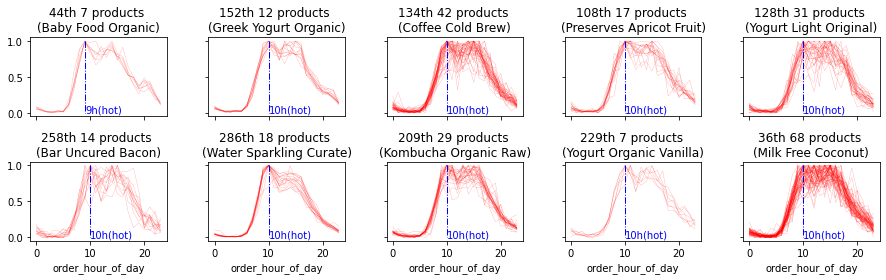

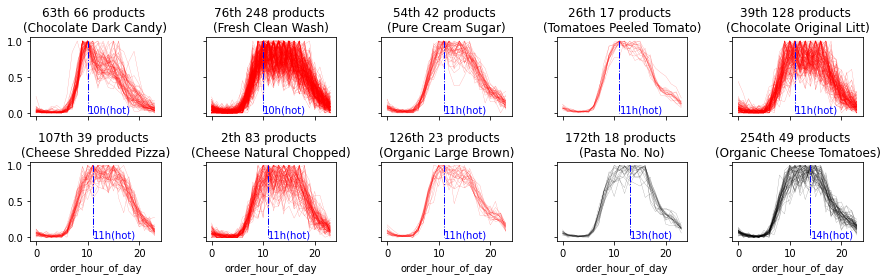

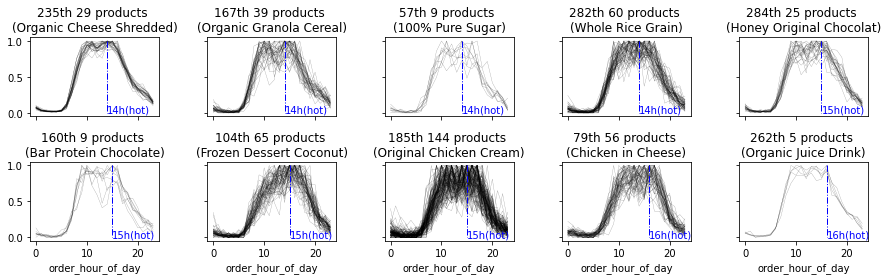

In [ ]:
ncols, nrows=(5,2) # 30 세트만 확인
step = 10
for n in np.arange(0,300,ncols*nrows*step):
    drawHODCluster(ncols, nrows, n, step)

# 2. 추천 시스템 활용 방안
* 클러스터링으로 나눠진 상품그룹으로 **타겟 마케팅**을 진행할 수 있습니다.
* EDA를 통해 발견한 **마케팅 인사이트에 위의 추천시스템을 함께 적용할 수 있습니다.**
* 특정 타이밍, 필요 수량, 어떤 상품인지 등 고객의 상황에 맞게 상품을 추천해야 하는데  
    ① 기존 구매 목록을 기반으로 구매한 상품 일부와  
    ② 같은 카테코리로 분류된 유사한 제품을 적절히 조합하여 추천합니다.  
    → 어느정도 수준으로 혼합 해야할지는 상황에 따라 가설을 세워 검증할 수 있습니다. 

# 3. 한계점 및 추후 발전방향
* 상품군이 너무 많으므로 제한된 수로는 동일 분류가 아닌 상품도 많이 포함됩니다. 상품들간의 연관성이 잘 구성될 수 있도록 **클러스터링 수를 최적화** 하기 위한 노력이 필요합니다. 클러스터링 수를 더 늘려서 세분화 하거나, 오히려 줄여서 포괄적으로 상품 추천을 할 경우에 어느쪽이 더 구매에 긍정적인 영향을 주는지 검증하고 싶습니다.

* **대시보드**를 간단한 실적 확인용으로 구성했는데, 더 디테일한 사항들도 확인 할 수 있도록 추가하면 좋을 것 같습니다. 또한 회사내 **매출 실적 외에 시장 동향**이나 참고하면 좋을 트렌드들을 크롤링하여 한번에 볼 수 있게 구성하면 유용할 것 같습니다. 예를 들어 매출의 가장 큰 비중을 차지하는 농수산물 생산량 및 가격 트렌드나 시즌별 검색어 트렌드(유행하는 제품, 이슈제품이 있는지)등을 함께 포함하면 마케팅 활동 의사결정에 도움이 될 것 같습니다.

* **상품 추천 시스템**을 구성하는 방식은 여러가지가 있는데, Product2Vec외에 다른방식으로 진행했을 때 어떤 차이가 생기는지 비교하여 성능을 파악하고, 고객 타겟팅을 정교화하고 싶습니다. 

* 이번 분석데이터에는 상품당 가격 자료나 동일 제품당 구매 수량정보 등이 없습니다. 수량만큼 가격정보가 중요한데, 이후에는 **가격 정보**가 있는 데이터로 **매출 분석**도 진행하고 싶습니다.